In [29]:
import warnings
from glob import glob

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# from category_encoders import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
from IPython.display import VimeoVideo
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import GridSearchCV

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
df = pd.read_csv("data/car_clean.csv")
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage(km/ltr/kg),engine,max_power,seats,Cars_Age,price_per_kilometer
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248.0,74.00,5.0,11,19230.769231
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498.0,103.52,5.0,11,17502.365184
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497.0,78.00,5.0,19,8926.553672
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396.0,90.00,5.0,15,9782.608696
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298.0,88.20,5.0,18,8074.534161


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6906 entries, 0 to 6905
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   name                 6906 non-null   object 
 1   year                 6906 non-null   int64  
 2   selling_price        6906 non-null   int64  
 3   km_driven            6906 non-null   int64  
 4   fuel                 6906 non-null   object 
 5   seller_type          6906 non-null   object 
 6   transmission         6906 non-null   object 
 7   owner                6906 non-null   object 
 8   mileage(km/ltr/kg)   6906 non-null   float64
 9   engine               6906 non-null   float64
 10  max_power            6906 non-null   float64
 11  seats                6906 non-null   float64
 12  Cars_Age             6906 non-null   int64  
 13  price_per_kilometer  6906 non-null   float64
dtypes: float64(5), int64(4), object(5)
memory usage: 755.5+ KB


In [4]:
df["brand"] = df["name"].str.split().str[0]

df["brand"].head()

0     Maruti
1      Skoda
2      Honda
3    Hyundai
4     Maruti
Name: brand, dtype: object

In [5]:
df['seller_type'].unique()

array(['Individual', 'Dealer', 'Trustmark Dealer'], dtype=object)

In [6]:
# drop columns that would constitute 'leakage'
df.drop(columns = ['price_per_kilometer'], inplace=True)

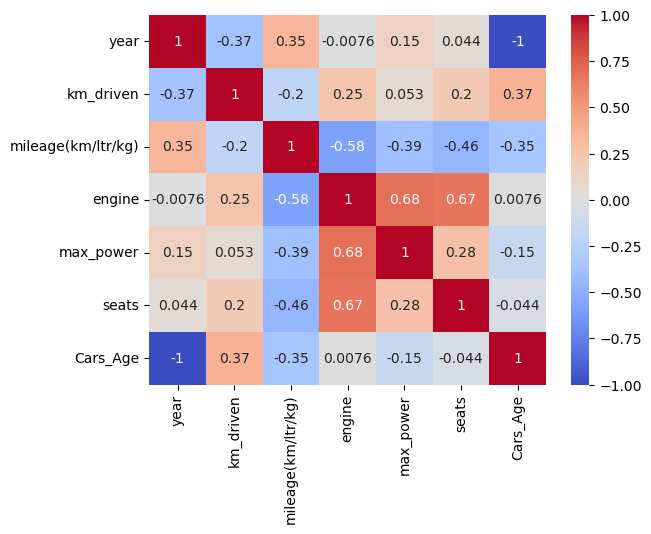

In [7]:
# check for multicollinearity 
numeric_cols = ['year', 'km_driven', 'mileage(km/ltr/kg)', 'engine', 'max_power', 'seats', 'Cars_Age'  ]
sns.heatmap( df[numeric_cols].corr(), annot=True, cmap='coolwarm')

plt.show()

## Split

In [9]:
target = "selling_price"
features = ([ "brand", "Cars_Age",
             "seats", "max_power","engine", 
             "mileage(km/ltr/kg)", "owner",
             "transmission", "seller_type","fuel", 
             "km_driven", "year"]
           )

y= df[target]
X= df[features]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [11]:
assert X_train.shape == (5524, 12), f"`X_train` is the wrong size: {X_train.shape}."
assert y_train.shape == (5524,), f"`y_train` is the wrong size: {y_train.shape}."

# Build Model

## Baseline

In [12]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean]* len(y_train)

print(f"Mean Car selling price: ${y_mean.round(2)}")
print(f"Baseline MAE:", mean_absolute_error(y_train, y_pred_baseline))

Mean Car selling price: $499874.7
Baseline MAE: 271400.69761834474


## Iterate

In [13]:
# create a pipeline

model = make_pipeline(
    OneHotEncoder(handle_unknown='ignore'),
    SimpleImputer(),
    # Ridge(),
    LinearRegression()
    
)
                      

model.fit(X_train, y_train)

,steps,"[('onehotencoder', ...), ('simpleimputer', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,categories,'auto'
,drop,None
,sparse_output,True
,dtype,<class 'numpy.float64'>
,handle_unknown,'ignore'
,min_frequency,None
,max_categories,None


## Evaluate

In [14]:
y_pred_training =model.predict(X_train)

print("Training MAE:", mean_absolute_error(y_train, y_pred_training))

Training MAE: 52339.87961634194


In [15]:
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

0    812028.702743
1    194394.721577
2    382287.157028
3    334085.345621
4    171655.148132
dtype: float64

In [16]:
from sklearn.metrics import r2_score, mean_squared_error

# Predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# R² Scores
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

# Mean Squared Error
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

print("Training R²:", r2_train)
print("Testing R²:", r2_test)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)


Training R²: 0.9588210608523366
Testing R²: 0.8152452154865205
Training MSE: 7417454604.666586
Testing MSE: 33482700152.71392


In [27]:

# Initialize Lasso Regression
# alpha is the regularization strength (you can tune this value)
lasso = make_pipeline (OneHotEncoder(handle_unknown='ignore'), Lasso(alpha=0.1))

# Train the model
lasso.fit(X_train, y_train)

# Predictions
y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

# Evaluation
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

print("Lasso Training R²:", r2_train)
print("Lasso Testing R²:", r2_test)
print("Lasso Training MSE:", mse_train)
print("Lasso Testing MSE:", mse_test)

Lasso Training R²: 0.9588163392685696
Lasso Testing R²: 0.8120647917772341
Lasso Training MSE: 7418305091.201196
Lasso Testing MSE: 34059081293.245884


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.825e+13, tolerance: 9.950e+10
  model = cd_fast.sparse_enet_coordinate_descent(


In [28]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error

# Initialize Ridge Regression
ridge =make_pipeline(OneHotEncoder(handle_unknown='ignore'), Ridge(alpha=1.0))  # you can tune alpha

# Train the model
ridge.fit(X_train, y_train)

# Predictions
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

# Evaluation
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

print("Ridge Training R²:", r2_train)
print("Ridge Testing R²:", r2_test)
print("Ridge Training MSE:", mse_train)
print("Ridge Testing MSE:", mse_test)


Ridge Training R²: 0.9379590570589348
Ridge Testing R²: 0.8762841366688331
Ridge Training MSE: 11175272783.15459
Ridge Testing MSE: 22420751738.363647


In [ ]:
# Define Ridge regression
ridge = make_pipeline(OneHotEncoder(handle_unknown='ignore'),Ridge())

# Grid of alpha values to try
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100, 200, 500, 1000]}

# GridSearch with 5-fold CV
ridge_cv = GridSearchCV(ridge, param_grid, cv=5, scoring='r2', n_jobs=-1)

# Fit on training data
ridge_cv.fit(X_train, y_train)

# Best alpha
print("Best alpha:", ridge_cv.best_params_['alpha'])

# Best score
print("Best CV R² Score:", ridge_cv.best_score_)

# Evaluate on test data
best_ridge = ridge_cv.best_estimator_
y_pred_ridge = best_ridge.predict(X_test)

from sklearn.metrics import r2_score, mean_squared_error
print("Test R²:", r2_score(y_test, y_pred_ridge))
print("Test MSE:", mean_squared_error(y_test, y_pred_ridge))


In [24]:
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

# Define Ridge model with preprocessing
ridge_model = make_pipeline(OneHotEncoder(handle_unknown='ignore'), Ridge(alpha=1.0))

# 5-fold cross-validation (shuffle for randomness)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate using R²
r2_scores = cross_val_score(ridge_model, X, y, cv=cv, scoring="r2")

# Evaluate using negative MSE (need to take -1 * value because sklearn returns negative for losses)
mse_scores = cross_val_score(ridge_model, X, y, cv=cv, scoring="neg_mean_squared_error")

print("Cross-Validation R² Scores:", r2_scores)
print("Average R²:", np.mean(r2_scores))

print("Cross-Validation MSE Scores:", -mse_scores)  # convert back to positive
print("Average MSE:", -np.mean(mse_scores))


Cross-Validation R² Scores: [0.84670391 0.81269993 0.83340788 0.88438223 0.85132311]
Average R²: 0.8457034148200477
Cross-Validation MSE Scores: [2.78250562e+10 3.53472111e+10 3.07316790e+10 2.17022411e+10
 2.36488989e+10]
Average MSE: 27851017252.15954


# Communicate Results

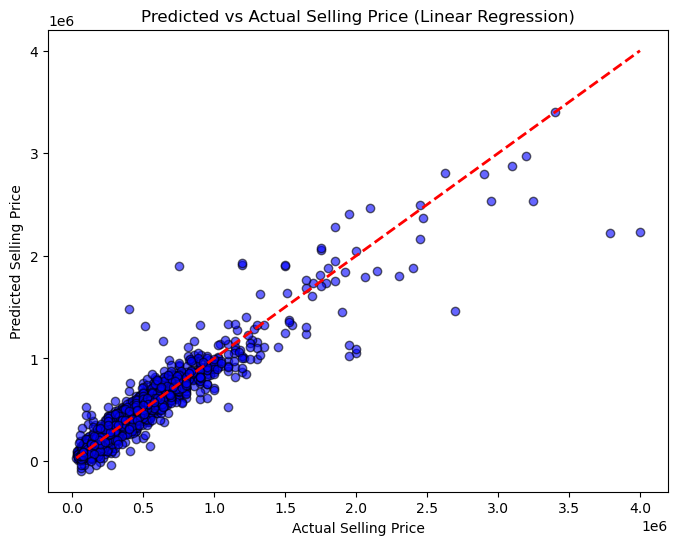

In [25]:
# Predict on test set
y_pred = y_pred_test

# Scatter plot: actual vs predicted
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6, color="blue", edgecolor="k")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         color="red", linestyle="--", linewidth=2)  # ideal line

plt.xlabel("Actual Selling Price")
plt.ylabel("Predicted Selling Price")
plt.title("Predicted vs Actual Selling Price (Linear Regression)")
plt.show()
